## Deep Hedge
Payoff to hedge: $Z$

Wealth process
$$
V_T = V_0 + (H\cdot S)_T.
$$
Evaluation of how good $V_{T}$ hedge $Z$ by how much money left after paying the payoff $Z$ to the client. We use convex risk measure $\rho$ , the smaller the better
$$
\rho(-Z + V_T).
$$
By cash invariant of convex risk measure we have 
$$
\rho(-Z + V_T) = \rho(-Z + V_T) = \rho\Big((H\cdot S)_T - Z\Big) - V_0,
$$
which means that the risk increase is indeed how much we subtract. Therefore, we do not need to minimized the risk over $V_0$

## Risk minimization
Our goal is to find the best strategy $H$ under $\rho$ to minimize the risk above:
$$
\min_{H} \rho\Big((H\cdot S)_T - Z\Big)
$$
We denote the minimal risk by $\pi(-Z)$. In particular we choose OCE measure 
$$
\rho(X) = \inf_{w \in \mathbb{R}}\{w + \mathbb{E}_{\mathbb{P}}[l(-X-w)]\}
$$
where $l(x)$ represent risk. 

## OCE risk
- Entropic risk measure: $l(x) = \exp(\lambda x) - \frac{1}{\lambda}(1+\log\lambda)$, $\lambda > 0$
$$
\rho(X) = \frac{1}{\lambda}\log\Big(\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)
$$
$$
\omega^{*} = \frac{1}{\lambda}\log\Big(\lambda\mathbb{E}_{\mathbb{P}}\big[\exp(-\lambda X)\big]\Big)
$$

- Expected shortfall: $l(x) = \frac{1}{1-\alpha}\max(x,0)$, $\alpha \in (0,1)$
$$
\rho(X) = \frac{1}{1-\alpha}\int_{0}^{1-\alpha}\mathrm{VaR}_{\gamma}(X)d\gamma
$$
$$
\omega^{*} = -\mathrm{VaR}_{1-\alpha}(X)
$$

- Square loss: $l(x) = \frac{x^2 + 1}{2}$
$$
\rho(X) = \frac{1}{2}\mathrm{Var}_{\mathbb{P}}[X] -  \mathbb{E}_{\mathbb{P}}[X]
$$
$$
\omega^{*} = -\mathbb{E}_{\mathbb{P}}[X]
$$




## Indifference prices
The indifference price is the initial endowment $v_0$ s.t. the minimal risk from hedging is indifference from the minimal risk from not hedging i.e. 
$$
\min_{H} \rho\Big(v_0 + (H\cdot S)_T - Z\Big) = \min_{H} \rho\Big((H\cdot S)_T \Big)
$$
Again, by the cash-invariant property we have 
$$
v_0 = \pi(-Z) - \pi(0)
$$


## Numerical Details

We parametrized the self-financing strategy $H = (\varphi, \theta)$ by holding of risky asset only. The terminal wealth $V_T = V_0 + (H\cdot S)_T$ would then computed by
$$
V_T = S^{1}_T\Big(\frac{V_0}{S^{1}_0} + (\theta \cdot \tilde{S})_T\Big), \quad \tilde{S} = \frac{S^{2:d}}{S^{1}},
$$
where $\tilde{S}$ is the discounted prices of risky assets. By consider neural network strategy $\theta = g(S_t, T-t)$, we finally numerically solve the following problems: 
$$
\pi(-Z) = \min_{\theta} \rho\Big(S^{1}_T (\theta \cdot \tilde{S})_T - Z \Big)
$$
$$
\pi(0) = \min_{H} \rho\Big(S^{1}_T (\theta \cdot \tilde{S})_T \Big)
$$

In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append('../src')

### Black-Scholes & European Call

In [2]:
import torch
from neuralhedge.nn import datahedger
from neuralhedge.utils.plotting import plot_hedge_ds
from neuralhedge.data.market import BS_Market
from neuralhedge.utils.evaluation import evaluate_bs_deep_hedge

Shape of paths:  torch.Size([10000, 31, 2])
Shape of information:  torch.Size([10000, 31, 2])
Shape of payoff:  torch.Size([10000])


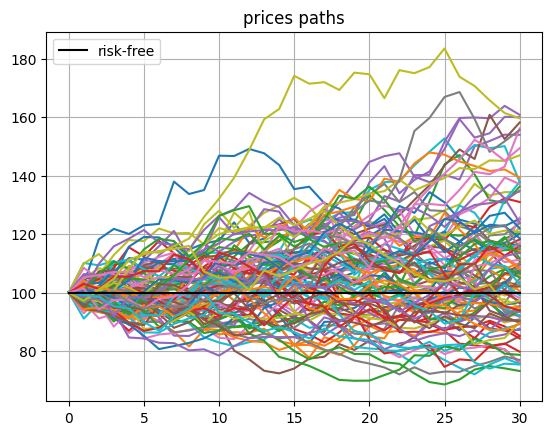

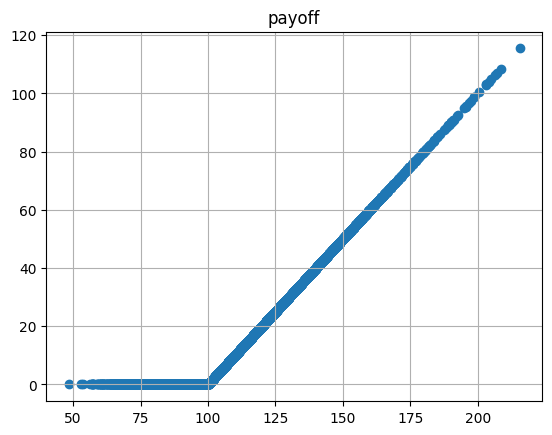

In [3]:
bs_market = BS_Market()
ds_train = bs_market.get_hedge_ds()
ds_test = bs_market.get_hedge_ds()
plot_hedge_ds(ds_train)

### Delta hedge

In [4]:
bs_price, bs_delta = bs_market.get_price_delta()
delta_hedger = datahedger.Hedger(bs_delta)
record_dir = './deephedge/bs_call_delta'
evaluate_bs_deep_hedge(delta_hedger, ds_test, bs_price, record_dir)

Save evaluation at: ./deephedge/bs_call_delta
Entropic Measure: 1.07
Square Measure: 1.29
Power Measure (p=1): 0.66
Expected Shortfall (q=0.5): 1.28
Expected Shortfall (q=0.9): 0.44


### Only Stock

In [5]:
class OnlyBond(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, x):
        return torch.zeros_like(x[...,:1])

only_bond = OnlyBond()
bond_hedger = datahedger.Hedger(only_bond)
record_dir = './deephedge/bs_call_onlybond'
evaluate_bs_deep_hedge(bond_hedger, ds_test, bs_price, record_dir)

Save evaluation at: ./deephedge/bs_call_onlybond
Entropic Measure: 98.26
Square Measure: 165.20
Power Measure (p=1): 10.08
Expected Shortfall (q=0.5): 20.16
Expected Shortfall (q=0.9): 8.38


### Data Hedger


In [6]:
from neuralhedge.nn import datahedger, network
from neuralhedge.nn.loss import EntropicRiskMeasure, SquareMeasure, ExpectedShortfall
from neuralhedge.utils.plotting import plot_hedge_ds
from neuralhedge.data.market import BS_Market
from neuralhedge.utils.evaluation import evaluate_bs_deep_hedge
from neuralhedge.utils.plotting import plot_history
from neuralhedge.nn.trainer import Trainer

#### Entropic Risk Measure

In [7]:
n_asset = ds_train.prices.shape[-1]
strategy = network.NeuralNetSequential(n_output = n_asset-1)
entropic_hedger = datahedger.Hedger(strategy, risk = EntropicRiskMeasure()) 
entropic_trainer = Trainer(entropic_hedger)
entropic_trainer.fit(ds_train, EPOCHS=500, lr_scheduler_gamma=1) 

/Users/hous/Github/NeuralHedge/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Loss=8.58287525177002: 100%|██████████| 500/500 [03:47<00:00,  2.20it/s]  


In [8]:
record_dir = './deephedge/bs_call_entropic'
plot_history(entropic_trainer.history, record_dir)
evaluate_bs_deep_hedge(entropic_hedger, ds_test, bs_price, record_dir)

Save evaluation at: ./deephedge/bs_call_entropic
Entropic Measure: 1.27
Square Measure: 1.41
Power Measure (p=1): 0.70
Expected Shortfall (q=0.5): 1.38
Expected Shortfall (q=0.9): 0.50


#### Square loss

In [9]:
strategy = network.NeuralNetSequential(n_output = n_asset-1)
square_hedger = datahedger.Hedger(strategy, risk = SquareMeasure()) 
square_trainer = Trainer(square_hedger)
square_trainer.fit(ds_train, EPOCHS=500, lr_scheduler_gamma=0.99) 

/Users/hous/Github/NeuralHedge/.venv/lib/python3.9/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
  0%|          | 0/500 [00:00<?, ?it/s]

Loss=11.419075965881348: 100%|██████████| 500/500 [03:50<00:00,  2.17it/s]


In [10]:
record_dir = './deephedge/bs_call_square/'
plot_history(square_trainer.history, record_dir)
evaluate_bs_deep_hedge(square_hedger, ds_test, bs_price, record_dir)

Save evaluation at: ./deephedge/bs_call_square/
Entropic Measure: 1.16
Square Measure: 0.69
Power Measure (p=1): 0.42
Expected Shortfall (q=0.5): 0.80
Expected Shortfall (q=0.9): 0.01
